# 主成分分析

*PCA: Principal Component Analysis*

次元削減を行う最も基本的な手法。

主成分分析では、データ空間$\R^l$内に$m$（$m\leq l$）個の互いに直行する軸を設定し、この軸にデータを射影することで次元を削減する。軸は射影後のデータの分散が最も大きくなるように定義する。  
なおこの軸は**主成分軸**と呼ぶ。

In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

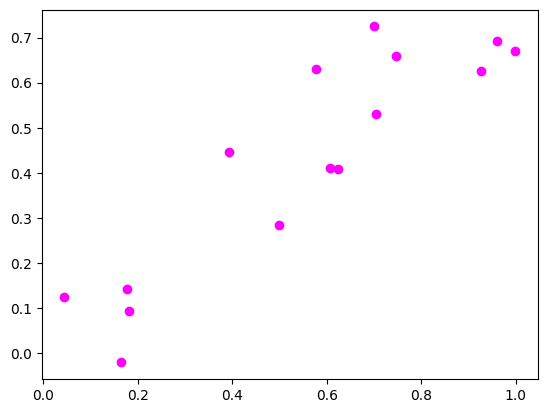

In [2]:
n = 15
a = 3/4
x1 = np.random.random(n)
x2 = a * x1
x2 += 0.1 * np.random.randn(n)
plt.scatter(x1, x2, color='magenta');

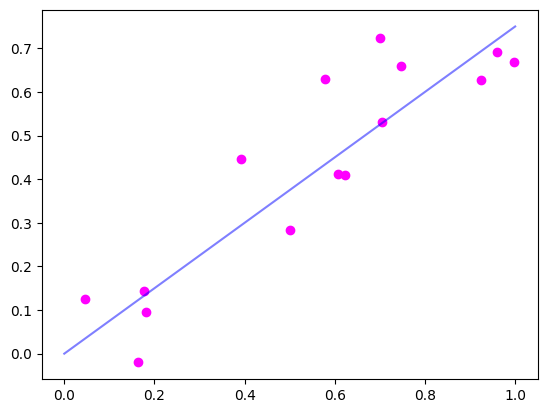

In [3]:
plt.plot([0, 1], [0, a], color='blue', alpha=0.5);
plt.scatter(x1, x2, color='magenta');

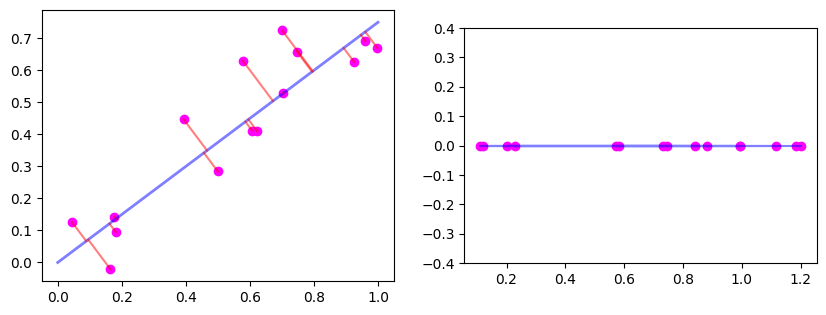

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_aspect('equal')
ax2.set_ylim(-0.4, 0.4)
ax2.set_aspect('equal')

x = np.array([0, 1])
y = x * 3/4
ax1.plot(x, y, color='blue', linewidth=2, alpha=0.5);

p1 = (x2 + x1/a) / (a + 1/a)
p2 = a * p1
pc = (p1**2 + p2**2)**0.5

for i in range(n):
    ax1.plot([x1[i], p1[i]], [x2[i], p2[i]], color='red', alpha=0.5)
ax1.scatter(x1, x2, color='magenta');

zeros = np.zeros_like(pc)
ax2.plot(pc, zeros, color='blue', alpha=0.5)
ax2.scatter(pc, zeros, color='magenta');


---

## 分散の最大化

主成分分析では主成分軸と呼ばれる軸を求めるが、その軸は射影後の分散が最大化になるように求める。

分散を最大化する目的について、納得のいく記述が少ない。データの違いが表れるように、とかがよく言われるけど、なんかしっくりこない。

ということで、分散を最大化する目的について、自分なりに考えてみた。そして、自分ではとても納得のいく説明が出来た。それをまとめる。

基礎となる考え方は、「多くの情報を残したい」である。  
次元を減らすことで、当然元のデータからいくらかの情報が失われることとなる。この失われる情報を最小にしたいという願い。

少し表現を変えて、次元削減したデータが多くの情報を持つようにしたい、とする。  
ここで、確率分布が持つ情報量について記述したとある理論を用いる。

### 情報理論

1950年頃にクロード・シャノンによって提唱された。確率変数や確率分布が持つ情報量を記述した理論。  
機械学習とも密接な関わりがあり、個人的には結構好きな分野。

情報理論では、確率分布$p(x)$が持つ情報量$H(p)$を以下のように定義する。

$$
H(p) = -\sum_x p(x)\log p(x)
$$

これは情報エントロピーと言ったりする。この式の意味はここでは理解しなくてよい。何となく載せただけ。

情報エントロピーは確率分布が持つ情報量を示す。また、それと同時に「予測のしにくさ」を表すともいわれている。  
つまりこの理論によると、予測がしにくいほど情報量が多いということになる。

実際に見てみよう。二つの正規分布を考える。

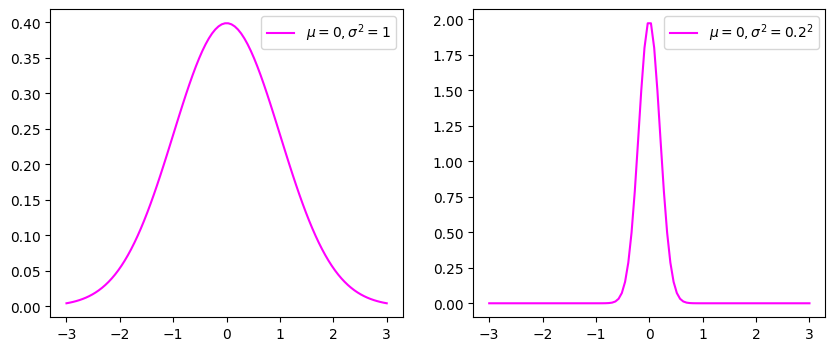

In [5]:
x = np.linspace(-3, 3, 100)
n1 = stats.norm.pdf(x, loc=0, scale=1)
n2 = stats.norm.pdf(x, loc=0, scale=0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(x, n1, label=r'$\mu=0, \sigma^2=1$', color='magenta')
ax1.legend()
ax2.plot(x, n2, label=r'$\mu=0, \sigma^2=0.2^2$', color='magenta')
ax2.legend();

左は分散$\sigma^2=1$、右は$\sigma^2=0.2^2$。  
グラフを見ると、左の方が予測がしにくそうだ。広く分布しているから。

情報エントロピーを見てみよう。  
正規分布の情報エントロピーは以下になる。

参考: [正規分布のエントロピーの導出 - Mooの技術メモ](https://moo-tech.hatenablog.com/entry/2021/11/11/203000)

$$
H = \frac{1}{2}\big(\log(2\pi\sigma^2) + 1\big)
$$

分散に対して単調増加なので、分散が大きい左の分布の方が情報エントロピーが大きい=多くの情報量を持つということになる。

In [6]:
H = lambda sigma: 1/2 * (np.log(2*np.pi*sigma**2) + 1)
print('左の正規分布の情報エントロピー', H(1))
print('右の正規分布の情報エントロピー', H(0.2))

左の正規分布の情報エントロピー 1.4189385332046727
右の正規分布の情報エントロピー -0.1904993792294276


以上より、分散が大きい分布は多くの情報量を持つことが分かった。  

ここから、主成分分析の目的が射影後の分散の最大化であることが納得できる。  
射影後に多くの情報が残るようにしたいから、分散を最大化する。


---

## 主成分軸の導出

では、目標を理解したところで、それを達成する軸=主成分軸を求めていこう。

### 図

資料用

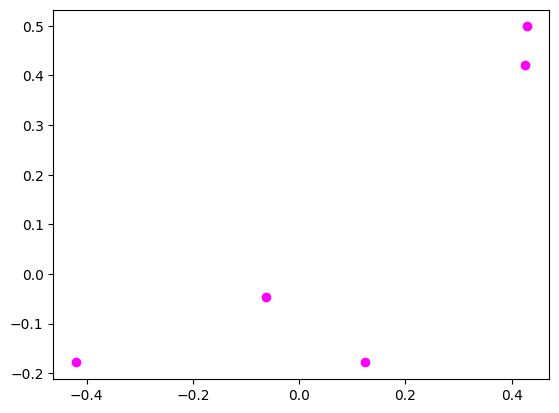

In [7]:
n = 5
a = 3/4
x1 = np.random.random(n) - 0.5
x2 = a * x1
x2 += 0.1 * np.random.randn(n)
plt.scatter(x1, x2, color='magenta');

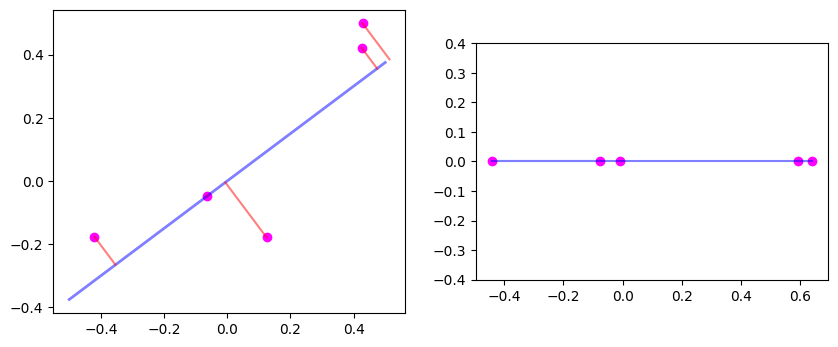

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_aspect('equal')
ax2.set_ylim(-0.4, 0.4)
ax2.set_aspect('equal')

x = np.array([-0.5, 0.5])
y = x * 3/4
ax1.plot(x, y, color='blue', linewidth=2, alpha=0.5);

p1 = (x2 + x1/a) / (a + 1/a)
p2 = a * p1
pc = (p1**2 + p2**2)**0.5 * np.sign(p1)

for i in range(n):
    ax1.plot([x1[i], p1[i]], [x2[i], p2[i]], color='red', alpha=0.5)
ax1.scatter(x1, x2, color='magenta');

zeros = np.zeros_like(pc)
ax2.plot(pc, zeros, color='blue', alpha=0.5)
ax2.scatter(pc, zeros, color='magenta');

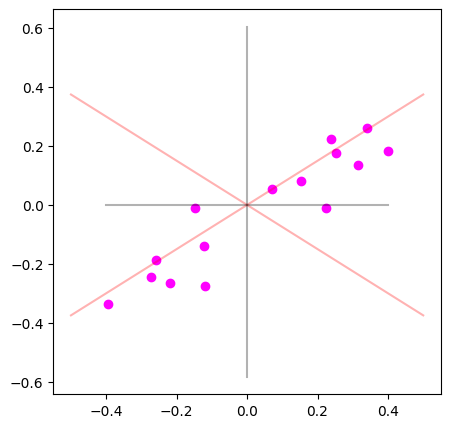

In [42]:
n = 15
a = 3/4
x1 = np.random.random(n) - 0.5
x2 = a * x1
x2 += 0.1 * np.random.randn(n)
plt.figure(figsize=(5, 5))

x = np.array([-0.5, 0.5])
plt.plot(x, a*x, color='red', alpha=0.3)
plt.plot(x, -a*x, color='red', alpha=0.3);
plt.plot([-0.4, 0.4], [0, 0], color='black', alpha=0.3)
plt.plot([0, 0], [pc1.min(), pc1.max()], color='black', alpha=0.3)
plt.scatter(x1, x2, color='magenta');

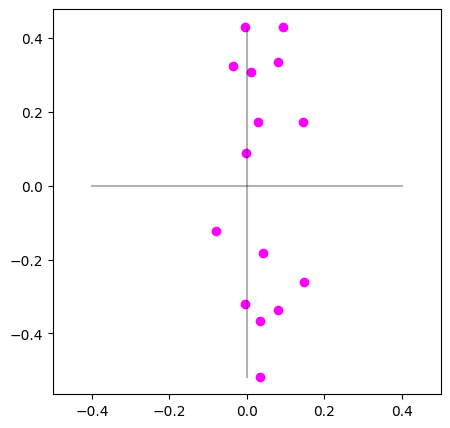

In [44]:
p1 = (x2 + x1/a) / (a + 1/a)
p2 = a * p1
pc1 = (p1**2 + p2**2)**0.5 * np.sign(p1)

ai = -1/a
p1 = (x2 + x1/ai) / (ai + 1/ai)
p2 = ai * p1
pc2 = (p1**2 + p2**2)**0.5 * np.sign(p1)

plt.figure(figsize=(5, 5))
plt.xlim(-0.5, 0.5)
plt.plot([-0.4, 0.4], [0, 0], color='black', alpha=0.3)
plt.plot([0, 0], [pc1.min(), pc1.max()], color='black', alpha=0.3)
plt.scatter(pc2, pc1, color='magenta');